# Predictive Maintenance of telemeters

## Background

A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

In this project, we will build a predictive model that can predict the probability of a device failure. We are provided with a dataset that contains telemetry readings from multiple devices transmitted on a daily basis. Device failure is indicated as '0' or '1' on the failure column in the dataset. The device metrics are marked as 'metric1'-'metric9'. Other variables available in the dataset are date and device ID.

In [44]:
import sklearn
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
import matplotlib
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]

## Overview and Approach

The approach I have followed for building the solution is as follows:

1. Perform an initial exploratory analysis where we look for trends, data quality, and any correlations between the available features.
2. We look more closely at the failed devices and develop a strategy for predicting failure possibly before failure has actually happened. One approach is to flag the rows of data, from failed devices, that are streamed a couple of days before failure takes place. 
3. Perform necessary pre-processing, data wrangling, and normalization of data to transform it into a format such that we can make it ready for apply machine learning and coming up with tangible results.
4. We shall observe later that this dataset is highly skewed. While there are about 100 rows labeled '1' indicating a failed device, there are more than 120,000 rows labeled '0'. Thus the dataset cannot be fed into a classification model as is since the model would likely learn to label everything as 0.
5. The approach we follow is to use an autoencoder neural network for learning the pattern behind the feature metrics of those devices that are not predicted to fail. For this autoencoder, we will select only those devices that are not predicted to fail
6. Perform a train-test split on the dataset.
7. Train the dataset on the training data and test the model on the test dataset.
8. Use the model to look at the Loss function for both successful devices and failed devices. If the model is good, there will be a vast difference between the two loss functions. Thus we have a neural network model that can predict which ones are the problematic devices.
9. We can now develop a model to define success/failure as a function of the loss function. Using this model we assign predicted values to all devices and check for metrics such as roc-auc score and f1-score to evaluate the usefulness of the final model. We might choose to go back and revisit the hyperparameters of the neural network to see if we can improve the model.

In [3]:
#read the data from the link provided
input_file=pd.read_csv("http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv") 

input_file.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [4]:
input_file.drop(columns=['date','device','failure']).describe()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


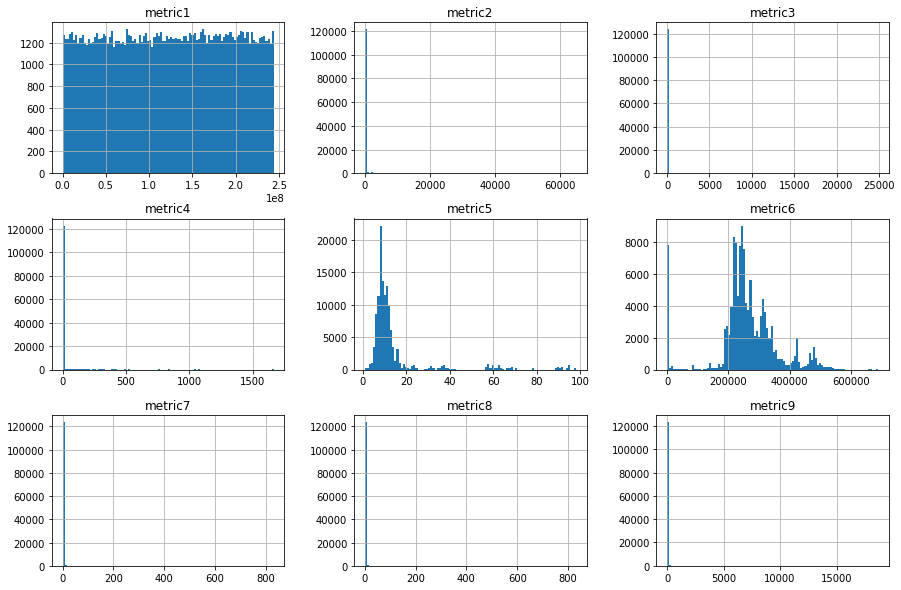

In [5]:
input_file_features = input_file.drop(columns=['date','device','failure'])

hist = input_file_features.hist(bins=100)

## Analysis of the data

A few things are clear from the statistical summary of the metric features and the plots of their distributions.
1. metric1, metric5, and metric6 have a wide range of values. However, all other metrics contain a significant number of zeros and some non-zero values.
2. The range of values for the different metrics are widely different, sometimes by several orders of magnitude.
3. metric7 and metric8 have identical distributions. It is likely that both of them are correlated. Therefore, we can remove one of them before we proceed with building the model.

I have also plotted all the relationships between every pair of metric features, as well as every metric feature versus the output (failure). Any correlations will be easily detected from this pairplot. I have used seaborn for plotting the pairplot.

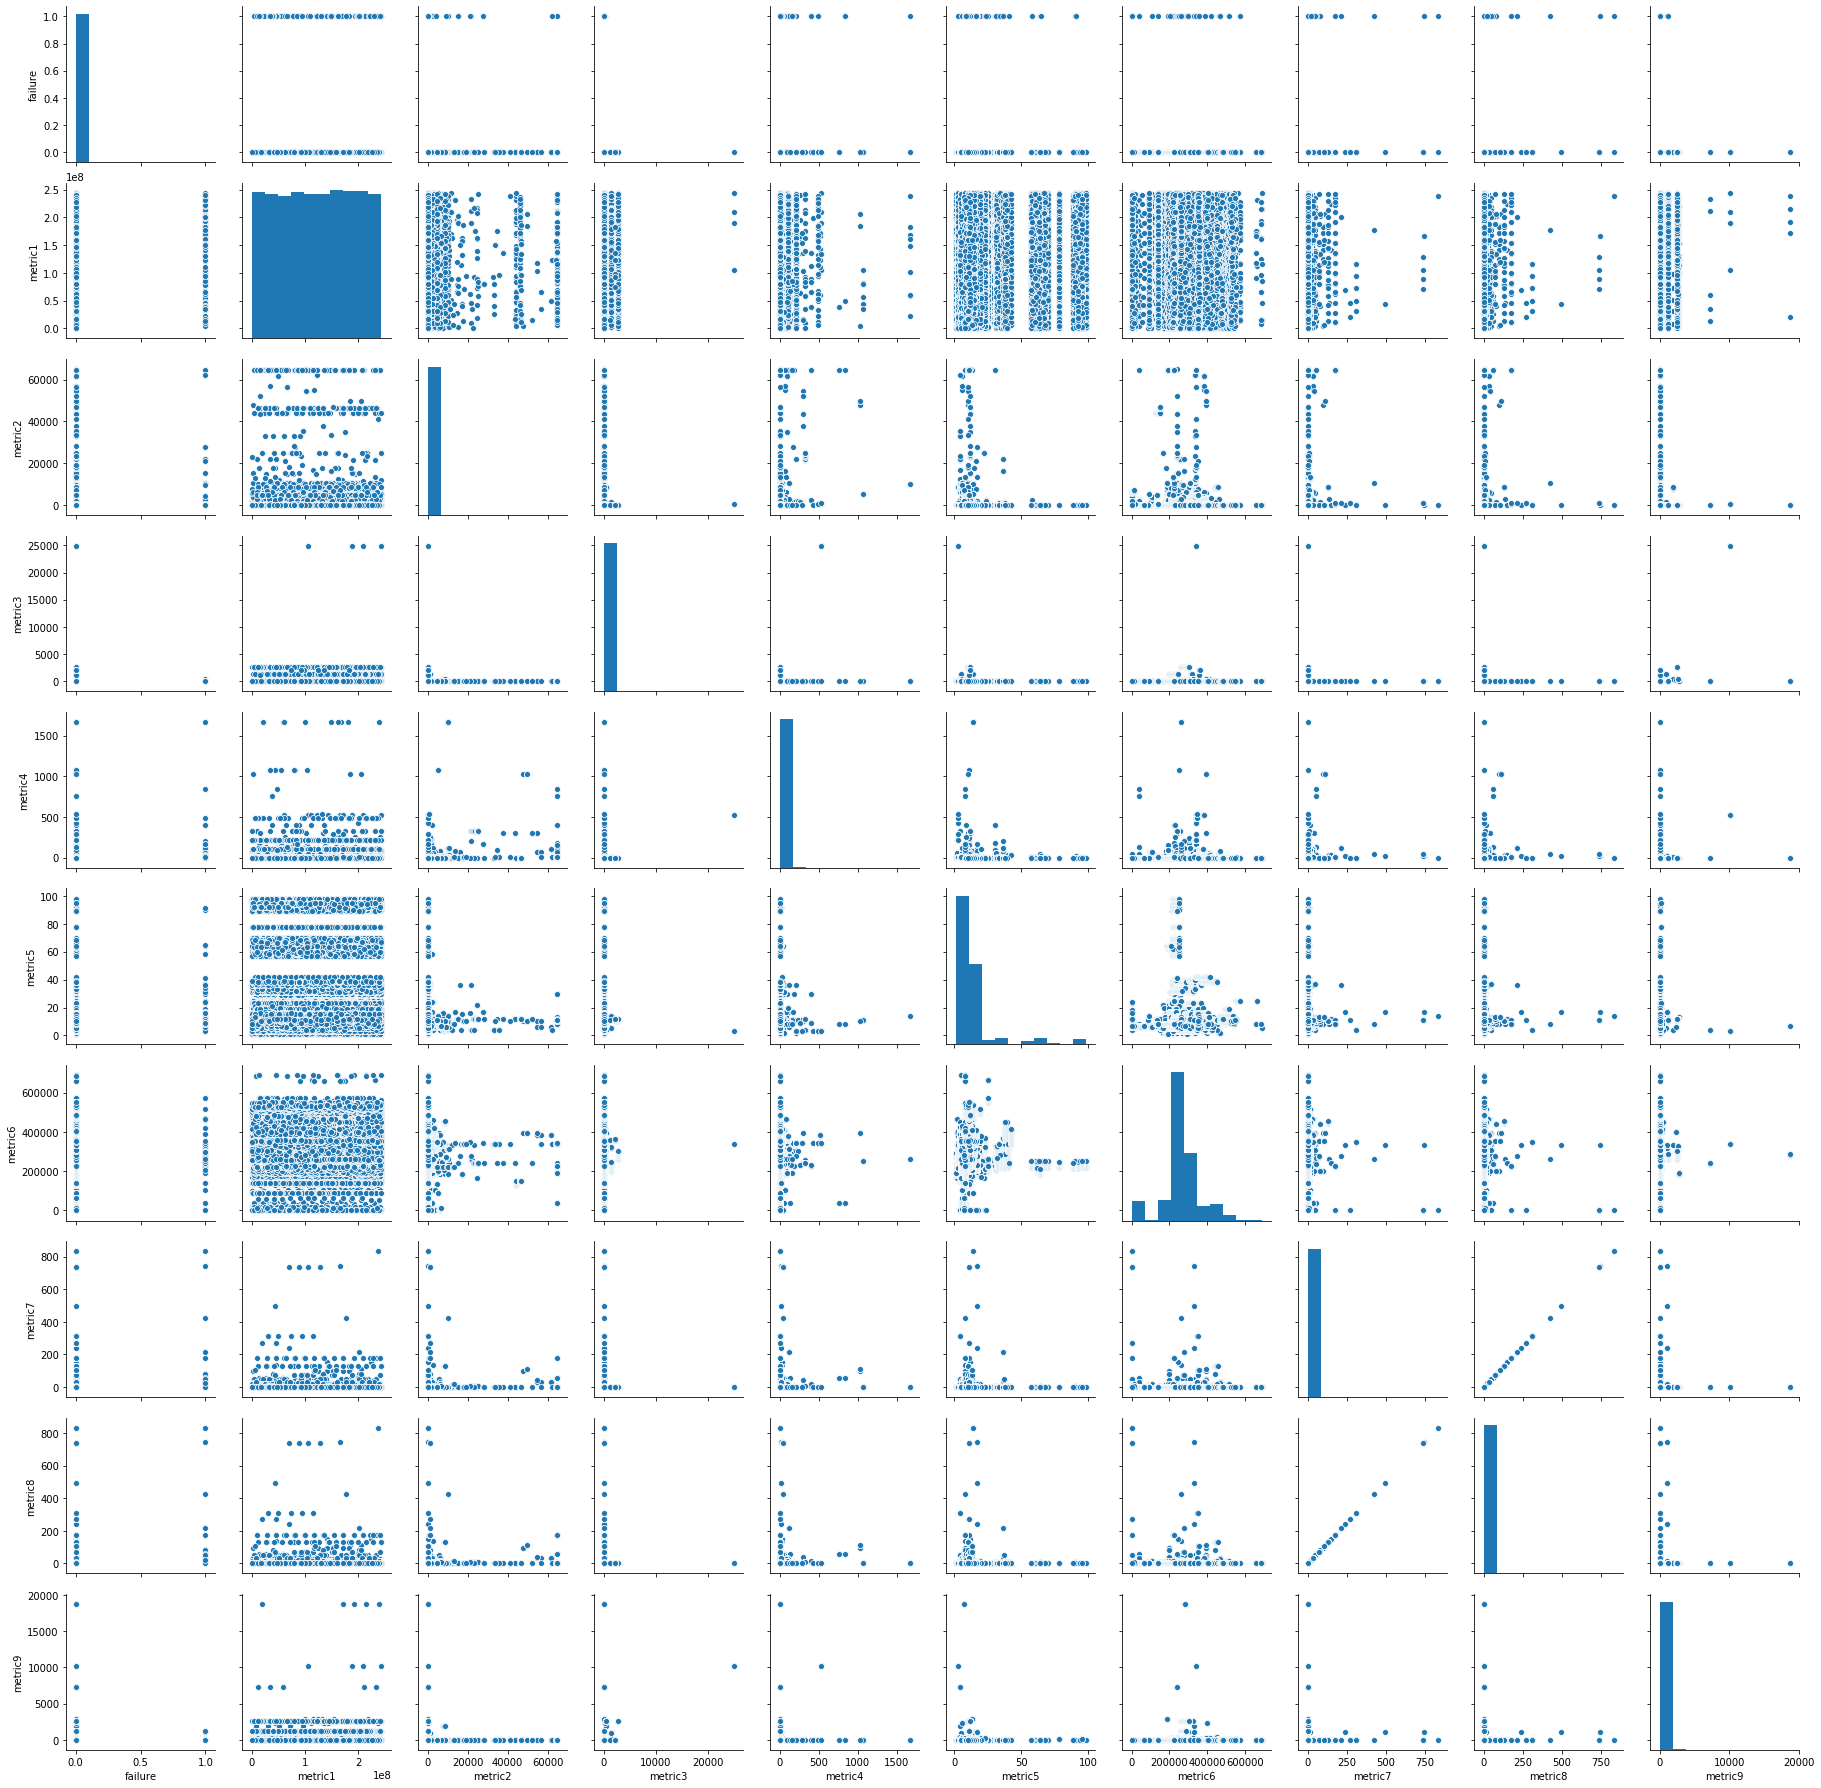

In [6]:
input_file_features_outcome = input_file.drop(columns=['date','device'])

sns.pairplot(input_file_features_outcome)

## Data Munging

In the following few steps, we will get the data ready for training. Based on our initial observations, the following steps can help better process the data.

1. We drop metric8 which is identical to metric7. Although features that are correlated often can give us additional information, in this case since the features are identical, there is no additional information to get from keeping both metric7 and metric8.
2. We convert the datatype of the 'date' field from string to a datetime. This will help us perform certain operations on the field.
3. <b>We observe that the data is highly skewed and thus proceed to perform some pre-processing to make the data ready for being fed into an autoencoder-based neural network</b>
4. We proceed to split the data into two parts: Rows that are labeled '0' and rows that are labeled '1'.

In [7]:
input_file_clean = input_file.drop(columns='metric8')

input_file_clean.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


In [8]:
input_file_clean['date']=pd.to_datetime(input_file_clean['date'])

input_file_clean.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


In [9]:
input_file_success=input_file_clean[input_file_clean['failure']==0]

input_file_success.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


In [10]:
input_file_success.shape

(124388, 11)

In [11]:
input_file_failure=input_file_clean[input_file_clean['failure']==1]

input_file_failure.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
4885,2015-01-05,S1F0RRB1,1,48467332,64776,0,841,8,39267,56,1
6879,2015-01-07,S1F0CTDN,1,184069720,528,0,4,9,387871,32,3
8823,2015-01-09,W1F0PNA5,1,136429411,64784,0,406,30,224801,8,0
11957,2015-01-13,W1F13SRV,1,188251248,2040,0,0,6,39345,32,1
12668,2015-01-14,W1F1230J,1,220461296,0,0,0,14,325125,0,0


In [12]:
input_file_failure.shape

(106, 11)

In [13]:
failed_devices=input_file_failure.groupby(by='device').head()

failed_devices.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
4885,2015-01-05,S1F0RRB1,1,48467332,64776,0,841,8,39267,56,1
6879,2015-01-07,S1F0CTDN,1,184069720,528,0,4,9,387871,32,3
8823,2015-01-09,W1F0PNA5,1,136429411,64784,0,406,30,224801,8,0
11957,2015-01-13,W1F13SRV,1,188251248,2040,0,0,6,39345,32,1
12668,2015-01-14,W1F1230J,1,220461296,0,0,0,14,325125,0,0


In [14]:
failed_devices.shape

(106, 11)

In [15]:
#Example of a failed device. Once the device fails, no further rows of data are available for that device
input_file_clean[input_file_clean['device']=='S1F0CTDN']

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
63,2015-01-01,S1F0CTDN,0,50147888,528,0,4,9,381198,32,3
1226,2015-01-02,S1F0CTDN,0,72104024,528,0,4,9,382459,32,3
2389,2015-01-03,S1F0CTDN,0,91492168,528,0,4,9,383713,32,3
3552,2015-01-04,S1F0CTDN,0,112311608,528,0,4,9,384948,32,3
4713,2015-01-05,S1F0CTDN,0,134261688,528,0,4,9,386214,32,3
5856,2015-01-06,S1F0CTDN,0,159974064,528,0,4,9,387343,32,3
6879,2015-01-07,S1F0CTDN,1,184069720,528,0,4,9,387871,32,3


## Re-labeling the devices

Now, we aim to predict devices that will fail before they actually fail. How soon before failure should this be predicted, can be a subjective decision. For my purposes, in this project I have used the threshold of 2 days.

We now add a new column called 'failure_prediction' to the dataset.

Using the dataset of failed devices, we proceed to label the failure_prediction column as 1 for those rows that are upto 2 days before the date of actual failure. For example, if device# S1F0RRB1 fails on 2015-01-05, then for the same device the dates 2015-01-03 and 2015-01-04 are marked as 1 in the failure_prediction column.

Subsequently, we proceed to further split the 'success' dataset into those where 'failure_prediction' is marked as 0 and those where it is marked as 1.

In [16]:
input_file_success['failure_prediction']=0

input_file_success.head()

/Users/anirbanbasu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,failure_prediction
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,0
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,0


In [17]:
input_file_success.shape

(124388, 12)

In [18]:
#Using the device# and the failure date, label 'failure_prediction'=1 for the same device going back to 2 days

def set_failure_prediction(device, failuredate):
    date_1 = failuredate -  pd.to_timedelta(1, unit='d')
    date_1 = date_1.strftime('%Y-%m-%d')

    date_2 = failuredate -  pd.to_timedelta(2, unit='d')
    date_2 = date_2.strftime('%Y-%m-%d')
    
    input_file_success.loc[(input_file_success['device']==device) 
                           & (input_file_success['date']==date_1), 'failure_prediction'] = 1

    input_file_success.loc[(input_file_success['device']==device) 
                           & (input_file_success['date']==date_2), 'failure_prediction'] = 1

In [19]:
for ind in input_file_failure.index:
    device = input_file_failure['device'][ind]
    failuredate = pd.to_datetime(input_file_failure['date'][ind], format='%Y%m%d', errors='ignore')
    set_failure_prediction(device, failuredate)

/Users/anirbanbasu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
input_file_success[input_file_success['device']=='W1F1230J']

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,failure_prediction
815,2015-01-01,W1F1230J,0,160609528,0,0,0,14,307719,0,0,0
1978,2015-01-02,W1F1230J,0,187043960,0,0,0,14,309041,0,0,0
3141,2015-01-03,W1F1230J,0,212033256,0,0,0,14,310378,0,0,0
4303,2015-01-04,W1F1230J,0,231117752,0,0,0,14,311765,0,0,0
5464,2015-01-05,W1F1230J,0,14394264,0,0,0,14,313068,0,0,0
6567,2015-01-06,W1F1230J,0,43272744,0,0,0,14,314337,0,0,0
7419,2015-01-07,W1F1230J,0,61165160,0,0,0,14,315687,0,0,0
8175,2015-01-08,W1F1230J,0,81394392,0,0,0,14,317064,0,0,0
8931,2015-01-09,W1F1230J,0,110557480,0,0,0,14,318382,0,0,0
9686,2015-01-10,W1F1230J,0,134310728,0,0,0,14,319719,0,0,0


In [21]:
input_file_success.shape

(124388, 12)

In [22]:
input_file_predicted_success = input_file_success[input_file_success['failure_prediction'] == 0]

input_file_predicted_success.shape

(124181, 12)

In [23]:
input_file_predicted_failure = input_file_success[input_file_success['failure_prediction'] == 1]

input_file_predicted_failure.shape

(207, 12)

## Implementing the Autoencoder

We now have 2 datasets: 1. Devices that are predicted to fail within the next 2 days; 2. Devices that are  predicted to remain functional over the next 2 days

We will use the dataset of devices predicted to remain functional and feed it into an autoencode-based neural network in order to generate a pattern for such devices. We will then use that model and test it on devices predicted to fail and look at the average loss function (which should be much larger than the average loss function for functional devices if the neural network is able to find a pattern).

Before training the neural network, we should drop the variables that are unlikely to have predictive value (for example date, device ID). We also remove the output variables.

Next, we normalize all the columns so that each feature has a range between 0 and 1. We use the method MinMaxScaler from the sklearn.preprocessing library.

In [24]:
input_file_predicted_success = input_file_predicted_success.drop(columns=['date','device','failure','failure_prediction'])

input_file_predicted_success.shape

(124181, 8)

In [25]:
input_file_predicted_success.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,215630672,56,0,52,6,407438,0,7
1,61370680,0,3,0,6,403174,0,0
2,173295968,0,0,0,12,237394,0,0
3,79694024,0,0,0,6,410186,0,0
4,135970480,0,0,0,15,313173,0,3


In [26]:
x = input_file_predicted_success.values #returns a numpy array of all values in the dataframe
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
input_file_predicted_success = pd.DataFrame(x_scaled, columns=input_file_predicted_success.columns)

In [27]:
input_file_predicted_success.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,0.883224,0.000862,0.00000,0.031212,0.051546,0.591204,0.0,0.000374
1,0.251374,0.000000,0.00012,0.000000,0.051546,0.585017,0.0,0.000000
2,0.709821,0.000000,0.00000,0.000000,0.113402,0.344461,0.0,0.000000
3,0.326427,0.000000,0.00000,0.000000,0.051546,0.595191,0.0,0.000000
4,0.556935,0.000000,0.00000,0.000000,0.144330,0.454420,0.0,0.000160


## Training the model

The dataset of functional devices is split into a training and test dataset. 75% of the data is used for training while 25% for test.

The neural network has 3 hidden layers, and an input and output layer. As is the case for Autoencoders, the input and output layers are identical. This allows the neural network to construct the hidden layers such that it is able to re-construct the input parameters at the output layer. However, since the neural network has been trained on the functional devices, it should ideally not be able to re-construct those devices that are predicted to fail (assuming that these two classes of devices are inherently different from each other based on their feature set).

The 3 hidden layers in the neural network has 7, 5, and 7 neurons respectively. The activation function used is RELU and Adam optimizer was used. Number of epochs is 25. Mean Squared Error has been used as the Loss function.

I also tried tanh as an activation function but RELU yielded better result. I also experimented with more hidden layers and more epochs but finally settled on these values which gave me optimum results considering the speed of training the network and the resulting output.

In [28]:
x_normal_train, x_normal_test = train_test_split(
    input_file_predicted_success, test_size=0.25, random_state=42)

In [29]:
model = Sequential()
model.add(Dense(7, input_dim=8, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(8)) # Output layer has same dimension as input
model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
model.fit(x_normal_train,x_normal_train,verbose=1,epochs=25)




Epoch 1/25





93135/93135 [==============================] - 8s 91us/step - loss: 0.0018
Epoch 2/25
93135/93135 [==============================] - 5s 57us/step - loss: 1.9162e-04
Epoch 3/25
93135/93135 [==============================] - 5s 57us/step - loss: 1.8574e-04
Epoch 4/25
93135/93135 [==============================] - 5s 58us/step - loss: 1.8540e-04
Epoch 5/25
93135/93135 [==============================] - 5s 57us/step - loss: 1.8534e-04
Epoch 6/25
93135/93135 [==============================] - 5s 57us/step - loss: 1.8525e-04
Epoch 7/25
93135/93135 [==============================] - 5s 56us/step - loss: 1.5571e-04
Epoch 8/25
93135/93135 [==============================] - 5s 58us/step - loss: 6.1621e-05
Epoch 9/25
93135/93135 [==============================] - 5s 57us/step - loss: 5.4704e-05
Epoch 10/25
93135/93135 [==============================] - 5s 57us/step - loss: 5.4573e-05
Epoch 11/25
93135/93135 [==============================] - 5s 59us/step - loss: 5.4325e-05
Epoc

In [57]:
model.layers[3]

In [58]:
hidden_representation = Sequential()
hidden_representation.add(model.layers[0])
hidden_representation.add(model.layers[1])

In [36]:
input_file_predicted_success.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,0.883224,0.000862,0.00000,0.031212,0.051546,0.591204,0.0,0.000374
1,0.251374,0.000000,0.00012,0.000000,0.051546,0.585017,0.0,0.000000
2,0.709821,0.000000,0.00000,0.000000,0.113402,0.344461,0.0,0.000000
3,0.326427,0.000000,0.00000,0.000000,0.051546,0.595191,0.0,0.000000
4,0.556935,0.000000,0.00000,0.000000,0.144330,0.454420,0.0,0.000160


In [37]:
input_file_predicted_success.shape

(124181, 8)

In [34]:
input_file_predicted_failure = input_file_predicted_failure.drop(columns=['date','device','failure','failure_prediction'])

input_file_predicted_failure.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
2561,26258330,64776,0,135,8,39267,56,1
3724,37985862,64776,0,763,8,39267,56,1
4713,134261688,528,0,4,9,386214,32,3
5856,159974064,528,0,4,9,387343,32,3
7303,88355682,64784,0,405,30,224801,8,0


In [38]:
x = input_file_predicted_failure.values #returns a numpy array of all values in the dataframe
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
input_file_predicted_failure = pd.DataFrame(x_scaled, columns=input_file_predicted_success.columns)

In [39]:
input_file_predicted_failure.shape

(207, 8)

In [60]:
input_file_predicted_failure.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,0.101143,0.999877,0.0,0.081032,0.056818,0.068299,0.067308,0.000858
1,0.149582,0.999877,0.0,0.457983,0.056818,0.068299,0.067308,0.000858
2,0.547234,0.008150,0.0,0.002401,0.068182,0.672132,0.038462,0.002575
3,0.653435,0.008150,0.0,0.002401,0.068182,0.674097,0.038462,0.002575
4,0.357626,1.000000,0.0,0.243097,0.306818,0.391206,0.009615,0.000000


In [52]:
norm_hid_rep = hidden_representation.predict(input_file_predicted_success[:300])
failed_hid_rep = hidden_representation.predict(input_file_predicted_failure)

In [46]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();

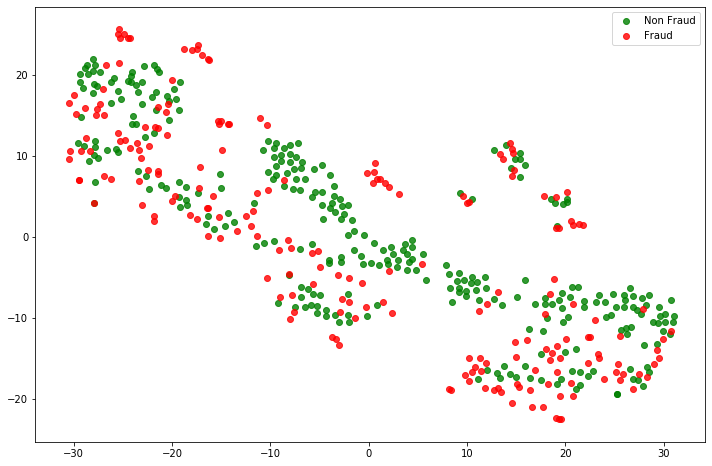

In [59]:
rep_x = np.append(norm_hid_rep, failed_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(failed_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

## Evaluating the model

We use the model that was developed in the previous step to evaluate the Root Mean Square Error on the training dataset, test dataset, and the dataset as a whole (all functional devices).

As seen below, in all 3 cases the RMSE is between 0.005 and 0.007.

Next we compute the mean square error in each row and add this as a new column. This column is added to the dataset and will be as a predictive feature in a subsequent step.

In [31]:
pred_normal = model.predict(x_normal_train)
score1 = np.sqrt(metrics.mean_squared_error(pred_normal,x_normal_train))
pred_normal_test = model.predict(x_normal_test)
score2 = np.sqrt(metrics.mean_squared_error(pred_normal_test,x_normal_test))
pred_overall = model.predict(input_file_predicted_success)
score3 = np.sqrt(metrics.mean_squared_error(pred_overall,input_file_predicted_success))

print(f"In-sample Functional Devices Score (RMSE): {score1}".format(score1))
print(f"Out of sample Functional Devices Score (RMSE): {score2}")
print(f"All Functional Devices Score (RMSE): {score3}")

In-sample Functional Devices Score (RMSE): 0.013583133998337864
Out of sample Functional Devices Score (RMSE): 0.012650820971886259
All Functional Devices Score (RMSE): 0.013356152776551722


In [32]:
error_matrix_success = np.square(np.subtract(pred_overall, input_file_predicted_success))

error_matrix_success['average'] = error_matrix_success.mean(axis=1)

error_matrix_success['average'].median()

9.020117478130497e-07

In [33]:
input_file_predicted_success['error']=error_matrix_success['average']
input_file_predicted_success['failure']=0

input_file_predicted_success.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,error,failure
0,0.883224,0.000862,0.00000,0.031212,0.051546,0.591204,0.0,0.000374,1.185045e-04,0
1,0.251374,0.000000,0.00012,0.000000,0.051546,0.585017,0.0,0.000000,6.414676e-07,0
2,0.709821,0.000000,0.00000,0.000000,0.113402,0.344461,0.0,0.000000,9.379589e-07,0
3,0.326427,0.000000,0.00000,0.000000,0.051546,0.595191,0.0,0.000000,6.850689e-07,0
4,0.556935,0.000000,0.00000,0.000000,0.144330,0.454420,0.0,0.000160,7.504963e-07,0


## Testing the model on devices predicted to fail

We next test the model on those devices that are predicted to fail within the next 2 days. As before, we first drop all the irrelevant columns as well as the output variables ('failure' and 'failure_prediction').

We notice below that the RMSE of these devices is around 0.076 which is more than 10 times that of the functional devices. This proves that these devices are fundamentally different from the previous ones and can be called out.

As before, we proceed to compute the mean square error in each row and add it as a new column.

In [34]:
input_file_predicted_failure.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,failure_prediction
2561,2015-01-03,S1F0RRB1,0,26258330,64776,0,135,8,39267,56,1,1
3724,2015-01-04,S1F0RRB1,0,37985862,64776,0,763,8,39267,56,1,1
4713,2015-01-05,S1F0CTDN,0,134261688,528,0,4,9,386214,32,3,1
5856,2015-01-06,S1F0CTDN,0,159974064,528,0,4,9,387343,32,3,1
7303,2015-01-07,W1F0PNA5,0,88355682,64784,0,405,30,224801,8,0,1


In [35]:
input_file_predicted_failure = input_file_predicted_failure.drop(columns=['date','device','failure','failure_prediction'])

x = input_file_predicted_failure.values #returns a numpy array of all values in the dataframe
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
input_file_predicted_failure = pd.DataFrame(x_scaled, columns=input_file_predicted_failure.columns)

input_file_predicted_failure.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,0.101143,0.999877,0.0,0.081032,0.056818,0.068299,0.067308,0.000858
1,0.149582,0.999877,0.0,0.457983,0.056818,0.068299,0.067308,0.000858
2,0.547234,0.008150,0.0,0.002401,0.068182,0.672132,0.038462,0.002575
3,0.653435,0.008150,0.0,0.002401,0.068182,0.674097,0.038462,0.002575
4,0.357626,1.000000,0.0,0.243097,0.306818,0.391206,0.009615,0.000000


In [36]:
pred_outliers = model.predict(input_file_predicted_failure)
score4 = np.sqrt(metrics.mean_squared_error(pred_outliers,input_file_predicted_failure))

print(f"Likely to fail (RMSE): {score4}")

Likely to fail (RMSE): 0.10091637870900345


In [37]:
error_matrix_likely_failure = np.square(np.subtract(pred_outliers, input_file_predicted_failure))

error_matrix_likely_failure['average'] = error_matrix_likely_failure.mean(axis=1)

error_matrix_likely_failure['average'].median()

3.3842167388548306e-05

In [38]:
input_file_predicted_failure['error']=error_matrix_likely_failure['average']
input_file_predicted_failure['failure']=1

input_file_predicted_failure.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,error,failure
0,0.101143,0.999877,0.0,0.081032,0.056818,0.068299,0.067308,0.000858,0.125772,1
1,0.149582,0.999877,0.0,0.457983,0.056818,0.068299,0.067308,0.000858,0.151232,1
2,0.547234,0.008150,0.0,0.002401,0.068182,0.672132,0.038462,0.002575,0.000176,1
3,0.653435,0.008150,0.0,0.002401,0.068182,0.674097,0.038462,0.002575,0.000176,1
4,0.357626,1.000000,0.0,0.243097,0.306818,0.391206,0.009615,0.000000,0.132484,1


Finally, we test the model on those devices that fail. Once again, we first drop all the irrelevant columns as well as the output variable ('failure').

For these devices, the RMSE is even higher and around 0.088. 

Once again, we compute the mean square error in each row and add it as a new column.

In [39]:
failed_devices = failed_devices.drop(columns=['date','device','failure'])

x = failed_devices.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
failed_devices = pd.DataFrame(x_scaled, columns=failed_devices.columns)

failed_devices.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,0.184054,0.999877,0.0,0.504802,0.056818,0.068299,0.067308,0.000858
1,0.752061,0.008150,0.0,0.002401,0.068182,0.675015,0.038462,0.002575
2,0.552507,1.000000,0.0,0.243697,0.306818,0.391206,0.009615,0.000000
3,0.769576,0.031489,0.0,0.000000,0.034091,0.068435,0.038462,0.000858
4,0.904496,0.000000,0.0,0.000000,0.125000,0.565811,0.000000,0.000000


In [40]:
pred_failed = model.predict(failed_devices)
score5 = np.sqrt(metrics.mean_squared_error(pred_failed,failed_devices))

print(f"Already failed (RMSE): {score5}")

Already failed (RMSE): 0.11491611789862285


In [41]:
error_matrix_failure = np.square(np.subtract(pred_failed, failed_devices))

error_matrix_failure['average'] = error_matrix_failure.mean(axis=1)

error_matrix_failure['average'].median()

5.4029725791819915e-05

In [42]:
failed_devices['error']=error_matrix_failure['average']
failed_devices['failure']=1

failed_devices.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,error,failure
0,0.184054,0.999877,0.0,0.504802,0.056818,0.068299,0.067308,0.000858,1.568696e-01,1
1,0.752061,0.008150,0.0,0.002401,0.068182,0.675015,0.038462,0.002575,1.749603e-04,1
2,0.552507,1.000000,0.0,0.243697,0.306818,0.391206,0.009615,0.000000,1.324861e-01,1
3,0.769576,0.031489,0.0,0.000000,0.034091,0.068435,0.038462,0.000858,2.630787e-04,1
4,0.904496,0.000000,0.0,0.000000,0.125000,0.565811,0.000000,0.000000,9.070994e-07,1


## Predicting device failure from Mean Squared Error

We now build a combined dataset containing all successful and failed devices. We want to build a classification model for predicting failure using the features in this dataset and in particular we want to use the error derived from the autoencoder as we have shown that to be an important predictive feature.

Since the error is extremely small, I have defined a new column derived using the logarithmic value of the error.

As an initial basic classification model I decided to use only this log of error as the predictive feature while using a simple logistic regression. Alternate approaches include using a random forest, which has been used later. However, as we shall see, we arrived at decent roc-auc and f1-scores even with this basic logistic regression model. 

In [43]:
df_success_failure = input_file_predicted_success.append(input_file_predicted_failure, ignore_index=True)

df_success_failure = df_success_failure.append(failed_devices, ignore_index=True)

In [44]:
df_success_failure['log_error'] = np.log10(df_success_failure['error'])

df_success_failure.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,error,failure,log_error
0,0.883224,0.000862,0.00000,0.031212,0.051546,0.591204,0.0,0.000374,1.185045e-04,0,-3.926265
1,0.251374,0.000000,0.00012,0.000000,0.051546,0.585017,0.0,0.000000,6.414676e-07,0,-6.192825
2,0.709821,0.000000,0.00000,0.000000,0.113402,0.344461,0.0,0.000000,9.379589e-07,0,-6.027816
3,0.326427,0.000000,0.00000,0.000000,0.051546,0.595191,0.0,0.000000,6.850689e-07,0,-6.164266
4,0.556935,0.000000,0.00000,0.000000,0.144330,0.454420,0.0,0.000160,7.504963e-07,0,-6.124651


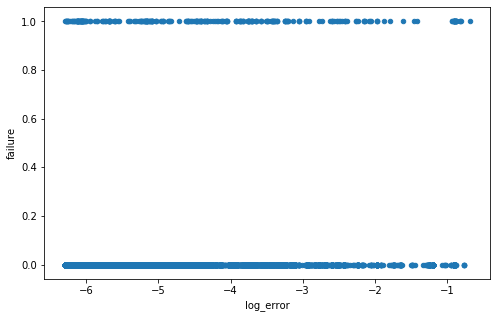

In [45]:
plt.rcParams["figure.figsize"] = [8, 5]

df_success_failure.plot.scatter(x='log_error', y='failure')

In [46]:
df_success_failure[df_success_failure['failure']==0]['log_error'].median()

-6.044787806164092

In [47]:
df_success_failure[df_success_failure['failure']==1]['log_error'].median()

-4.411458355826413

In [48]:
df_success = df_success_failure[df_success_failure['failure']==0]

df_success.shape

(124181, 11)

In [49]:
df_failure = df_success_failure[df_success_failure['failure']==1]

df_failure.shape

(313, 11)

## Training the Logistic Regression model

For this model we use a slightly modified dataset where we use a more balanced training dataset. While doing this, we do run the risk of missing out on a large number of potential training data, but given that we are using just the error column as our predictive feature and not all of the metrics (which contain much more information for us), it might be relatively harmless to use just a sample of the full set of successful devices.

We notice that in this combined dataset we have 313 rows with failure_prediction = 1. For our set of successful devices, we choose a sample of 250 and use the resultant dataset to train a logistic regression model

In [50]:
df_success = df_success_failure[df_success_failure['failure']==0]
df_failure = df_success_failure[df_success_failure['failure']==1]

df_success = df_success.sample(n = 250)

In [51]:
df_train_logistic = df_success.append(df_failure, ignore_index=True)

df_train_logistic.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,error,failure,log_error
0,0.225853,0.0,0.0,0.0,0.103093,0.353459,0.0,0.000000,6.580424e-07,0,-6.181746
1,0.539984,0.0,0.0,0.0,0.907216,0.349940,0.0,0.000000,1.548162e-06,0,-5.810184
2,0.605645,0.0,0.0,0.0,0.072165,0.357241,0.0,0.000481,9.238801e-07,0,-6.034384
3,0.273857,0.0,0.0,0.0,0.154639,0.475202,0.0,0.000000,6.474324e-07,0,-6.188806
4,0.257077,0.0,0.0,0.0,0.041237,0.331402,0.0,0.000000,7.298721e-07,0,-6.136753


## Predicting probabilities from the Logistic Regression model and evaluating its results

After performing a train, test split on the data, we go ahead and use the model to predict probabilities.

We can choose to use different thresholds for probability in order to predict either success or failure for our devices. I experimented with different probability threshold to see what gives us a decent roc-auc score. The roc-auc score we get is 0.86.

Subsequently, I use the same model to predict probabilties for the entire dataset and then using the same threshold for predicting success/failure, I calculate the roc-auc and f1-score of the model on this larger dataset. For the larger dataset, our roc-auc score is 0.83 while <b>f1-score is 0.96</b>.

<b>When tested on the complete dataset, the model predicts 72% of the failed devices correctly while nearly 92% of the functional devices are predicted correctly. Depending on different threshold probabilities, we can decrease the number of False negatives at the cost of higher False positives.</b>

In [52]:
x_train, x_test = train_test_split(
    df_train_logistic, test_size=0.25, random_state=1)

In [53]:
X = x_train['log_error'].values.reshape(-1, 1)
y = x_train['failure']
clf = LogisticRegression().fit(X, y)

prediction_probability = clf.predict_proba((x_test['log_error']).values.reshape(-1, 1))[:,1]

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[61  2]
 [19 59]]


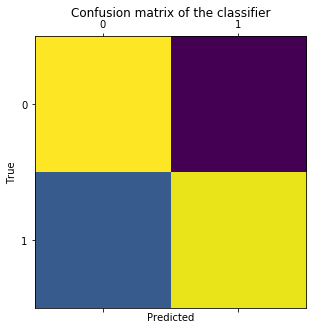

In [54]:
predicted_state = []

for i in prediction_probability:
    if i > 0.5:
        state = 1
    else:
        state = 0
    predicted_state.append(state)
    
cm = confusion_matrix(x_test['failure'], predicted_state)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [55]:
roc_auc_score(x_test['failure'], predicted_state)

0.8623321123321124

[[114683   9498]
 [    85    228]]


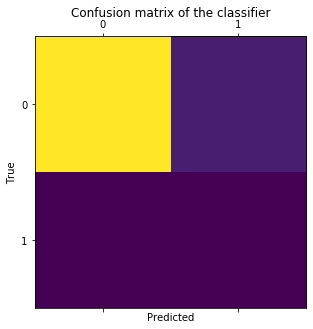

In [56]:
full_prediction = clf.predict_proba(df_success_failure['log_error'].values.reshape(-1, 1))[:,1]

predicted_state = []

for i in full_prediction:
    if i > 0.5:
        state = 1
    else:
        state = 0
    predicted_state.append(state)

predicted_state

cm = confusion_matrix(df_success_failure['failure'], predicted_state)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [57]:
roc_auc = roc_auc_score(df_success_failure['failure'], predicted_state)
print (f"ROC AUC Score: {roc_auc}".format(roc_auc))

f1 = f1_score(df_success_failure['failure'], predicted_state, average='weighted')
print (f"F1 Score: {f1}".format(f1))

ROC AUC Score: 0.8259746871084008
F1 Score: 0.9575960620404774


## Applying a Random Forest model

Shown below is an alternative approach using a Random Forest model which potentially gives slightly better results than the Logistic regression model from before.

For this, I chose a larger sample from the successful (functional) devices so we get the benefit of more information from those rows. However, we set the 'class_weight' hyperparameter to 'balanced' so that the model attaches weights inversely proportional to class frequencies. Thus, the frequency of 1 being much lower, the cost of misclassification is much higher than for 0.

I experimented with fine tuning the model using different number of trees and different depth. The final model used has a depth of 5 and number of trees (n_estimators) as 6.

In [58]:
df_success = df_success_failure[df_success_failure['failure']==0]
df_failure = df_success_failure[df_success_failure['failure']==1]

df_success = df_success.sample(n = 5000)

df_train_randomforest = df_success.append(df_failure, ignore_index=True)

df_train_randomforest.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,error,failure,log_error
0,0.214746,0.0,0.0,0.000000,0.134021,0.370893,0.0,0.0,6.329615e-07,0,-6.198623
1,0.152850,0.0,0.0,0.000000,0.113402,0.363347,0.0,0.0,6.121071e-07,0,-6.213173
2,0.941402,0.0,0.0,0.003601,0.319588,0.333527,0.0,0.0,2.555779e-06,0,-5.592477
3,0.444564,0.0,0.0,0.000000,0.051546,0.361539,0.0,0.0,7.802039e-07,0,-6.107792
4,0.339243,0.0,0.0,0.000000,0.092784,0.476521,0.0,0.0,6.413288e-07,0,-6.192919


In [59]:
x_train, x_test = train_test_split(
    df_train_randomforest, test_size=0.25, random_state=1)

In [60]:
X = x_train.drop(columns=['failure', 'error'])
y = x_train['failure']

clf = RandomForestClassifier(max_depth=5, n_estimators=6, random_state=0, class_weight='balanced')
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=6, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

## Evaluation of the Random Forest model.

Just as before, we first predict probabilities on the test dataset and then try to predict 1 and 0 based on different threshold probability values.

Just as in the case of the Logistic regression model, I found the threshold value of 0.5 to be optimum.

The Random Forest model yielded better results than the Logistic Regression. In particular, I was able to reduce both False positives and False negatives significantly thus improving both the roc-auc score as well as the f1-score.

<b>The final model, when tested on the complete dataset, yielded a roc-auc score of 0.89 and an f1-score of 0.97</b>

[[1174   76]
 [  16   63]]


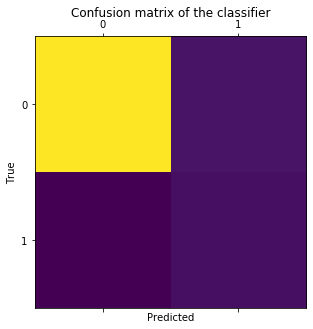

In [61]:
prediction_probability = clf.predict_proba(x_test.drop(columns=['failure','error']))[:,1]

predicted_state = []

for i in prediction_probability:
    if i > 0.5:
        state = 1
    else:
        state = 0
    predicted_state.append(state)
    
cm = confusion_matrix(x_test['failure'], predicted_state)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [62]:
roc_auc_score(x_test['failure'], predicted_state)

0.8683341772151899

In [63]:
f1_score(x_test['failure'], predicted_state, average='weighted')

0.9394502655513409

[[117156   7025]
 [    53    260]]


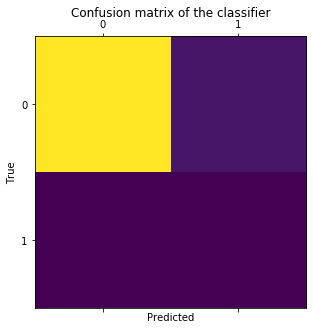

In [64]:
full_prediction = clf.predict_proba(df_success_failure.drop(columns=['failure','error']))[:,1]

predicted_state = []

for i in full_prediction:
    if i > 0.5:
        state = 1
    else:
        state = 0
    predicted_state.append(state)

predicted_state

cm = confusion_matrix(df_success_failure['failure'], predicted_state)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [65]:
roc_auc = roc_auc_score(df_success_failure['failure'], predicted_state)
print (f"ROC AUC Score: {roc_auc}".format(roc_auc))

f1 = f1_score(df_success_failure['failure'], predicted_state, average='weighted')
print (f"F1 Score: {f1}".format(f1))

ROC AUC Score: 0.8870501378064221
F1 Score: 0.9684097665541919
